# Kaggle上的titanic disaster数据分类问题

**题目中提到的重要信息：**
* 这是一个二分类问题，根据旅客的信息判断旅客是否可以在这场灾难中存活下来（0 = No, 1 = Yes）
* 存活下来除了有运气的成分之外，有一些人更有可能存活下来：women、children、the upper-class

根据参考文献[1]中的内容，计划workflow如下：
1. 数据集清理和格式化
2. 探索性数据分析
3. 特征工程和特征选择
4. 基于性能指标比较几种机器学习模型
5. 对最佳模型执行超参数调整
6. 在测试集上评估最佳模型
7. 解释模型结果
8. 得出结论

# Imports

In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size']=24

from IPython.core.pylabtools import figsize

import seaborn as sns
sns.set(font_scale=1.5)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. 数据处理
## 1.1 加载数据

In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**这里是数据中每一个字段的具体含义：**

| Tables        | Are           | Cool  |
| ------------- |:-------------:| -----:|
|survival	|Survival	|0 = No, 1 = Yes|
|pclass	|Ticket class	|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex	|Sex	|
|Age	|Age in years|	
|sibsp	|# of siblings / spouses aboard the Titanic	|
|parch	|# of parents / children aboard the Titanic	|
|ticket	|Ticket number	|
|fare	|Passenger fare	|
|cabin	|Cabin number	|
|embarked	|Port of Embarkation	|C = Cherbourg, Q = Queenstown, S = Southampton|

**题目中的Overview中提到了，women、children、the upper-class存活下来的概率更大，所以接下来，我们可能要更加注重pclass、sex、age这三个字段**

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


使用data.info()看到，所有的列都使用了正确的数据类型，并没有出现包含数字的列被存储为object类型

## 1.2 处理异常值


In [4]:
# 使用data.describe()查看数据的统计信息
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Text(0.5,1,'Survival Distribution')

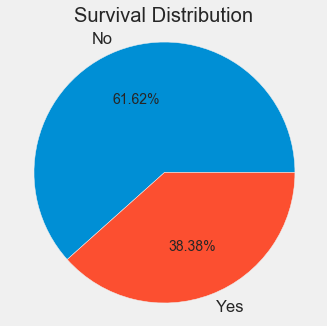

In [5]:
figsize(5,5)
plt.style.use('fivethirtyeight')
counts = train_data['Survived'].value_counts()
plt.pie(counts, labels=['No', 'Yes'], autopct='%1.2f%%')
plt.axis('equal')
plt.title('Survival Distribution')

Text(0.5,1,'Age Distribution')

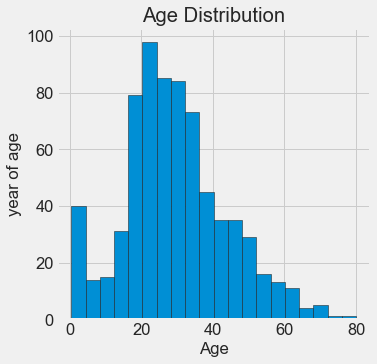

In [6]:
figsize(5,5)
plt.hist(train_data['Age'].dropna(), bins=20, edgecolor='k')
plt.xlabel('Age')
plt.ylabel('year of age')
plt.title('Age Distribution')

Text(0.5,1,'Ticket Class Distribution')

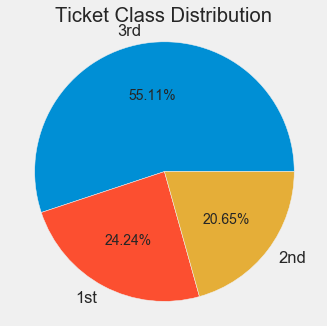

In [7]:
figsize(5,5)
counts = train_data['Pclass'].value_counts()
plt.pie(counts, labels=['3rd', '1st', '2nd'], autopct='%1.2f%%')
plt.axis('equal')
plt.title('Ticket Class Distribution')

male      577
female    314
Name: Sex, dtype: int64


Text(0.5,1,'Sex Distribution')

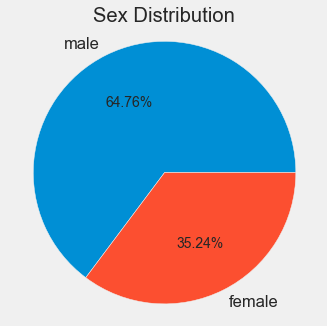

In [8]:
figsize(5,5)
counts = train_data['Sex'].value_counts()
print(counts)
plt.pie(counts, labels=['male', 'female'], autopct='%1.2f%%')
plt.axis('equal')
plt.title('Sex Distribution')

## 1.3 处理缺失值

In [9]:
print('Train columns with null values:\n', train_data.isnull().sum() / train_data.shape[0])
print("-"*10)

print('Test/Validation columns with null values:\n', test_data.isnull().sum() / test_data.shape[0])
print("-"*10)

Train columns with null values:
 PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64
----------
Test/Validation columns with null values:
 PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
dtype: float64
----------


In [10]:
for dataset in [train_data, test_data]:    
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
drop_column = ['Cabin','PassengerId', 'Ticket']
train_data.drop(drop_column, axis=1, inplace = True)

print(train_data.isnull().sum())
print("-"*10)
print(test_data.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


# 2. 特征工程与特征选择

## 2.2 特征工程

In [11]:
def create_features_for_data(data):
    data['Title'] = data['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    title_names = (data['Title'].value_counts() < 10) 
    data['Title'] = data['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
    
    label = LabelEncoder()
    features = ['Sex', 'Embarked', 'Title']
    for f in features:
        data[f+'_Code'] = label.fit_transform(data[f])
    
    data = data.drop(columns=features)
    data = data.drop(columns=['Name'])
    return data

train_data = create_features_for_data(train_data)
print('train data shape:',train_data.shape)
train_data.head(5)

train data shape: (891, 9)


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_Code,Embarked_Code,Title_Code
0,0,3,22.0,1,0,7.2500,1,2,3
1,1,1,38.0,1,0,71.2833,0,0,4
2,1,3,26.0,0,0,7.9250,0,2,2
3,1,1,35.0,1,0,53.1000,0,2,4
4,0,3,35.0,0,0,8.0500,1,2,3


## 2.3 特征选择（去除共线特征）


In [12]:
def remove_collinear_features(x, threshold):
    '''
    Objective:
       删除数据帧中相关系数大于阈值的共线特征。 删除共线特征可以帮助模型泛化并提高模型的可解释性。
        
    Inputs: 
        阈值：删除任何相关性大于此值的特征
    
    Output: 
        仅包含非高共线特征的数据帧
    '''
    
    # 不要删除能源之星得分之间的相关性
    y = x['Survived']
    x = x.drop(columns = ['Survived'])
    
    # 计算相关性矩阵
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # 迭代相关性矩阵并比较相关性
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # 如果相关性超过阈值
            if val >= threshold:
                # 打印有相关性的特征和相关值
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # 删除每对相关列中的一个
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    
    # 将得分添加回数据
    x['Survived'] = y
               
    return x

In [13]:
train_data = remove_collinear_features(train_data, 0.6)
print('train data shape:',train_data.shape)
train_data.head(5)

train data shape: (891, 9)


,Pclass,Age,SibSp,Parch,Fare,Sex_Code,Embarked_Code,Title_Code,Survived
0,3,22.0,1,0,7.2500,1,2,3,0
1,1,38.0,1,0,71.2833,0,0,4,1
2,3,26.0,0,0,7.9250,0,2,2,1
3,1,35.0,1,0,53.1000,0,2,4,1
4,3,35.0,0,0,8.0500,1,2,3,0


## 2.3 特征缩放

In [14]:
# max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
# train_data[['Age', 'Fare']] = train_data[['Age', 'Fare']].apply(max_min_scaler)
# train_data.head(5)

## 2.4 划分训练集合测试集

In [15]:
targets = train_data['Survived']
features = train_data.drop(columns=['Survived'])

X, X_valid, Y, Y_valid = train_test_split(features, targets, test_size = 0.3, random_state = 42)

print(X.shape)
print(X_valid.shape)
print(Y.shape)
print(Y_valid.shape)

(623, 8)
(268, 8)
(623,)
(268,)



# 3 对数据进行探索性分析


In [16]:
correlations_matrix = train_data.corr()['Survived'].sort_values()
print(correlations_matrix, '\n')

Sex_Code        -0.543351
Pclass          -0.338481
Embarked_Code   -0.167675
Title_Code      -0.083292
Age             -0.064910
SibSp           -0.035322
Parch            0.081629
Fare             0.257307
Survived         1.000000
Name: Survived, dtype: float64 



In [17]:
for x in train_data:
    if train_data[x].dtype != 'float64' and x not in ['Survived', 'Name']:
        print('Survival Correlation by:', x)
        print(train_data[[x, 'Survived']].groupby(x, as_index=False).mean())
        print('-' * 10, '\n')

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------- 

Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
---------- 

Survival Correlation by: Sex_Code
   Sex_Code  Survived
0         0  0.742038
1         1  0.188908
---------- 

Survival Correlation by: Embarked_Code
   Embarked_Code  Survived
0              0  0.553571
1              1  0.389610
2              2  0.339009
---------- 

Survival Correlation by: Title_Code
   Title_Code  Survived
0           0  0.575000
1           1  0.444444
2           2  0.697802
3           3  0.156673
4           4  0.792000
---------- 



# 4.基于性能指标比较几种机器学习模型

In [18]:
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn import model_selection
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
import scipy.stats

## 4.3 建立Baseline

In [19]:
baseline_accuracy = 1 - np.sum(targets)/targets.shape[0]
print('The baseline guess is %d' % 0)
print("Baseline Performance on the test set: accuracy = %0.4f" % baseline_accuracy)

The baseline guess is 0
Baseline Performance on the test set: accuracy = 0.6162


## 4.3 需要评估的模型

In [20]:
# machine learning algorithm
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(n_estimators=10),
    ensemble.BaggingClassifier(n_estimators=10),
    ensemble.ExtraTreesClassifier(n_estimators=10),
    ensemble.GradientBoostingClassifier(n_estimators=10),
    ensemble.RandomForestClassifier(n_estimators=10),

#     Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(cv=3, max_iter=1000),
    linear_model.PassiveAggressiveClassifier(max_iter=1000, tol=1e-3),
    linear_model.RidgeClassifierCV(cv=3),
    linear_model.SGDClassifier(max_iter=1000, tol=1e-3),
    linear_model.Perceptron(max_iter=1000, tol=1e-3),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True, gamma='scale'),
    svm.NuSVC(probability=True, gamma='scale'),
#     svm.LinearSVC(max_iter=1000),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis()
]

MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 
               'MLA Test Accuracy 3*STD', 'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)
row_index = 0
cv_split = model_selection.ShuffleSplit(n_splits = 5, test_size = .3, train_size = .6, random_state = 0)
for alg in MLA:
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    cv_results = model_selection.cross_validate(alg, X, Y, cv  = cv_split, return_train_score=True)
    
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3
    
    row_index+=1
    
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

c:\myprogram\python35\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
12,GaussianNB,"{'var_smoothing': 1e-09, 'priors': None}",0.810188,0.831016,0.0460514,0.00159583
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'n_estimators': 10, '...",0.83807,0.828877,0.0625463,0.00896711
19,QuadraticDiscriminantAnalysis,"{'tol': 0.0001, 'store_covariances': None, 're...",0.819303,0.824599,0.0371417,0.0017952
3,GradientBoostingClassifier,"{'min_impurity_split': None, 'tol': 0.0001, 'm...",0.83807,0.819251,0.0595099,0.00559039
18,LinearDiscriminantAnalysis,"{'tol': 0.0001, 'n_components': None, 'store_c...",0.794638,0.817112,0.0586385,0.00239382
8,RidgeClassifierCV,"{'class_weight': None, 'fit_intercept': True, ...",0.795174,0.817112,0.0568558,0.0315159
6,LogisticRegressionCV,"{'class_weight': None, 'tol': 0.0001, 'fit_int...",0.793566,0.810695,0.0425663,0.191082
1,BaggingClassifier,"{'bootstrap_features': False, 'max_features': ...",0.971582,0.804278,0.0482352,0.00997438
15,NuSVC,"{'class_weight': None, 'probability': True, 'k...",0.825201,0.802139,0.0442269,0.0299219
4,RandomForestClassifier,"{'class_weight': None, 'min_impurity_split': N...",0.969437,0.8,0.0482352,0.00797806


Text(0,0.5,'Algorithm')

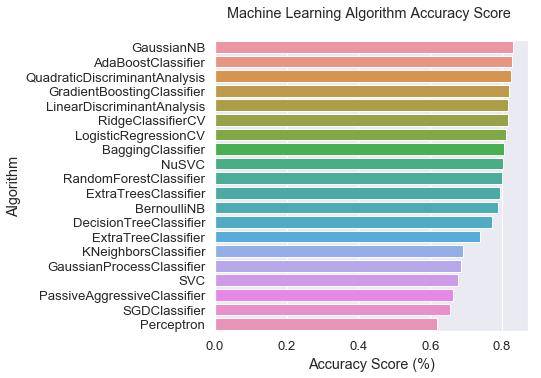

In [21]:
sns.set(font_scale=1.2)
sns.barplot(x = 'MLA Test Accuracy Mean', y = 'MLA Name', data=MLA_compare)
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

## 4.4 调节超参数


In [22]:
n_estimators = scipy.stats.randint(low=10, high=1000)
min_samples_leaf = [1,2,4,6,8]
min_samples_split = [2, 4, 6, 10]
max_depth = [2,4,6,8,10,None]
max_features = ['auto', 'sqrt', 'log2', None]

hyperparameter_grid = {'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features,
                       'max_depth': max_depth}

model = ensemble.RandomForestClassifier(random_state=0)
random_search = model_selection.RandomizedSearchCV(estimator=model,
                                               param_distributions=hyperparameter_grid,
                                               cv=8, n_iter=50, scoring='accuracy',
                                               n_jobs = -1, verbose = 1, 
                                               return_train_score = True,
                                               random_state=0)

In [ ]:
random_search.fit(X, Y)

Fitting 8 folds for each of 50 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.8s


In [ ]:
random_search_result = pd.DataFrame(random_search.cv_results_).sort_values('mean_test_score', ascending = False)
random_search_result.head(10)

In [ ]:
random_search.best_estimator_

In [ ]:
n_estimators = [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]
hyperparameter_grid = {'n_estimators': n_estimators}  
model = ensemble.RandomForestClassifier(**random_search.best_estimator_.get_params())

grid_search = model_selection.GridSearchCV(estimator=model,
                                           param_grid=hyperparameter_grid, 
                                           cv = 4, scoring='accuracy',
                                           verbose = 1,
                                           n_jobs = -1, 
                                           return_train_score = True)

In [ ]:
grid_search.fit(X, Y)

In [ ]:
grid_search_result = pd.DataFrame(grid_search.cv_results_).sort_values('mean_test_score', ascending = False)
grid_search_result.head(1)

In [ ]:
grid_search.best_estimator_

# 在测试集上评估模型

In [ ]:
def cal_accuracy(y_true, y_pred):
    return 1- np.sum(abs(y_true - y_pred)) / y_pred.shape[0]

final_model = grid_search.best_estimator_
final_model.fit(X, Y)
final_pred = final_model.predict(X_valid)
accuracy = cal_accuracy(Y_valid, final_pred)
print('Final model performance on the test set:  accuracy = %0.4f.' % accuracy)